In [1]:
# enron email classification

# Kaggle NN script to process enron classes  - n.b. I couldn't get hold of the datafile
# https://www.kaggle.com/markholland/enron-email-classification-using-word-embeddings/edit

# Script with Random Forests
# https://github.com/crossedbanana/Enron-Email-Classification

# Clean the enron emails i.e. extract message, from, to, date, time
# https://www.kaggle.com/ankur561999/data-cleaning-enron-email-dataset


# https://www.kaggle.com/ankur561999/enron-email-classification-using-machine-learning

In [2]:
import numpy as np
import pandas as pd
import time
import collections
import re
import random
import scipy.io
import glob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
#from sklearn import cross_validation, metrics   # cross_validation is deprecated
from sklearn.model_selection import cross_validate #,metrics

from sklearn.model_selection import GridSearchCV 

#from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

#from sklearn import cross_validation, metrics   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV

#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
#from nltk import PorterStemmer

C:\Users\marke\anaconda3\envs\tf-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\marke\anaconda3\envs\tf-gpu\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\marke\anaconda3\envs\tf-gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Embedding, Input, Conv1D, MaxPooling1D
#from tensorflow.keras.layers.merge import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [4]:
import os
import email

In [5]:
import re
import string
import time
pd.set_option('display.max_rows', 50)

from nltk.corpus import stopwords
stop = stopwords.words('english')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

In [6]:
# source: https://www.kaggle.com/wcukierski/enron-email-dataset
email_df = pd.read_csv('D:\\marke\\data\\enron\\data\\emails.csv')

In [7]:
email_df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [8]:
email_df.shape

(517401, 2)

In [9]:
print(email_df.loc[1]['message'])

Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>
Date: Fri, 4 May 2001 13:51:00 -0700 (PDT)
From: phillip.allen@enron.com
To: john.lavorato@enron.com
Subject: Re:
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.

As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the

In [10]:
# transform the email into correct format
message = email_df.loc[1]['message']
e = email.message_from_string(message)

e.items()

[('Message-ID', '<15464986.1075855378456.JavaMail.evans@thyme>'),
 ('Date', 'Fri, 4 May 2001 13:51:00 -0700 (PDT)'),
 ('From', 'phillip.allen@enron.com'),
 ('To', 'john.lavorato@enron.com'),
 ('Subject', 'Re:'),
 ('Mime-Version', '1.0'),
 ('Content-Type', 'text/plain; charset=us-ascii'),
 ('Content-Transfer-Encoding', '7bit'),
 ('X-From', 'Phillip K Allen'),
 ('X-To', 'John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>'),
 ('X-cc', ''),
 ('X-bcc', ''),
 ('X-Folder', "\\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail"),
 ('X-Origin', 'Allen-P'),
 ('X-FileName', 'pallen (Non-Privileged).pst')]

In [11]:
# get date
e.get('Date')

'Fri, 4 May 2001 13:51:00 -0700 (PDT)'

In [12]:
# show message body
e.get_payload()

"Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.  \n\nMy suggestion for where to go is Austin.  Play golf and rent a ski boat and jet ski's.  Flying somewhere takes too much time.\n"

In [13]:
# now we add those fields into our 'df' dataframe
def get_field(field, messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get(field))
    return column

In [14]:
email_df['date'] = get_field("Date", email_df['message'])
email_df['subject'] = get_field("Subject", email_df['message'])
email_df['X-Folder'] = get_field("X-Folder", email_df['message'])
email_df['X-From'] = get_field("X-From", email_df['message'])
email_df['X-To'] = get_field("X-To", email_df['message'])
email_df.head(3)

,file,message,date,subject,X-Folder,X-From,X-To
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Phillip K Allen,Leah Van Arsdall


In [15]:
def body(messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get_payload())
    return column

email_df['body'] = body(email_df['message'])
email_df.head(3)

,file,message,date,subject,X-Folder,X-From,X-To,body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Phillip K Allen,Leah Van Arsdall,test successful. way to go!!!


In [16]:
def preprocess_folder(folders):
    column = []
    for folder in folders:
        if (folder is None or folder == ""):
            column.append(np.nan)
        else:
            column.append(folder.split("\\")[-1].lower())
    return column

email_df['X-Folder'] = preprocess_folder(email_df['X-Folder'])
email_df.head(2)

,file,message,date,subject,X-Folder,X-From,X-To,body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",,'sent mail,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,Here is our forecast\n\n
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,'sent mail,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...


In [17]:
# count unique folders
print("Unique Folders: ", len(email_df['X-Folder'].unique()))

Unique Folders:  1782


In [18]:
def replace_empty_with_nan(subject):
    column = []
    for val in subject:
        if (val == ""):
            column.append(np.nan) 
        else:
            column.append(val)
    return column

In [19]:
email_df['subject'] = replace_empty_with_nan(email_df['subject'])
email_df['X-To'] = replace_empty_with_nan(email_df['X-To'])

In [20]:
email_df.isnull().sum()

file            0
message         0
date            0
subject     19187
X-Folder       29
X-From         29
X-To         9153
body            0
dtype: int64

In [21]:
# drop missing value rows
email_df.dropna(axis=0, inplace=True)

In [22]:
def body(messages):
    column = []
    for message in messages:
        e = email.message_from_string(message)
        column.append(e.get_payload())
    return column

email_df['body'] = body(email_df['message'])
email_df.head(3)

,file,message,date,subject,X-Folder,X-From,X-To,body
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,'sent mail,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,'sent mail,Phillip K Allen,Leah Van Arsdall,test successful. way to go!!!
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",Re: Hello,'sent mail,Phillip K Allen,Greg Piper,Let's shoot for Tuesday at 11:45.


In [23]:
df = email_df[['subject','X-Folder','body']]

In [24]:
# save the data
df.to_csv("D:\\marke\\data\\enron\\data\\cleaned_data.csv", index=False)

In [25]:
# Now process as per second kaggle script

In [26]:
# Remove folders with not enough emails
def remove_folders(emails, n):
    # returns the number of folders containing more than 'n' number of emails
    email_count = dict(df['X-Folder'].value_counts())
    small_folders = [key for key, val in email_count.items() if val<=n]
    emails = df.loc[~df['X-Folder'].isin(small_folders)]
    return emails

In [27]:
n = 150
df = remove_folders(df, n)

In [28]:
print("Total folders: ", len(df['X-Folder'].unique()))
print("df.shape: ", df.shape)

Total folders:  82
df.shape:  (460141, 3)


In [29]:
# Combine subject and body
df['text'] = df['subject'] + " " + df['body']
# drop the columns 'subject' and 'body'
df.drop(['subject','body'], axis=1, inplace=True)

In [30]:
df['text']

1         Re: Traveling to have a business meeting takes...
2                   Re: test test successful.  way to go!!!
4             Re: Hello Let's shoot for Tuesday at 11:45.  
5         Re: Hello Greg,\n\n How about either next Tues...
7         Re: PRC review - phone calls any morning betwe...
                                ...                        
517396    Trade with John Lavorato This is a trade with ...
517397    Gas Hedges Some of my position is with the Alb...
517398    RE: CONFIDENTIAL 2\n\n -----Original Message--...
517399    Calgary Analyst/Associate Analyst\t\t\t\t\tRan...
517400    RE: ali's essays i think the YMCA has a class ...
Name: text, Length: 460141, dtype: object

In [31]:
no_words_arr = []
for text in df['text']:
    no_words = len(text.split())
    no_words_arr.append(no_words)
    
df['no_words'] = no_words_arr

In [32]:
df[df['no_words'] < 100].shape[0]

198523

In [33]:
# shape of the data
df.shape

(460141, 3)

In [34]:
df['X-Folder'].value_counts().sort_values()

sun devil                151
5_00                     153
eol & tagg               157
old messages             158
pan energy swap          162
                       ...  
inbox                  40203
deleted items          49124
discussion threads     54353
sent                   54848
all documents         121985
Name: X-Folder, Length: 82, dtype: int64

In [35]:
# save the data
df.to_csv("D:\\marke\\data\\enron\\data\\cleaned_data.csv", index=False)

In [36]:
# Preprocess text: lowercasing all words, 
# Remove extra new lines, 
# Remove extra tabs, punctuations, commas
# Remove extra white spaces
# Remove stopwords

def preprocess(x):
    # lowercasing all the words
    x = x.lower()
    
    # remove extra new lines
    x = re.sub(r'\n+', ' ', x)
    
    # removing (replacing with empty spaces actually) all the punctuations
    x = re.sub("["+string.punctuation+"]", " ", x)
    
    # remove extra white spaces
    x = re.sub(r'\s+', ' ', x)
    
    return x

In [37]:
start = time.time()
df.loc[:,'text'] = df.loc[:, 'text'].map(preprocess)

# remove stopwords
df.loc[:, 'text'] = df.loc[:, 'text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
end = time.time()
print("Execution time (sec): ",(end - start))

Execution time (sec):  668.9623289108276


In [38]:
# Randomly select 20 folders
start = time.time()
folders_dict = dict(df['X-Folder'].value_counts().sort_values()[50:70])
data = df[df['X-Folder'].isin(folders_dict.keys())]
end = time.time()
print("Execution time (sec): ",(end - start))

Execution time (sec):  0.08612322807312012


In [39]:
# check number of rows in the 'data' dataframe
print("Number of instances: ", data.shape[0])
data.to_csv('D:\\marke\\data\\enron\\data\\preprocessed.csv', index=False)

Number of instances:  13586


In [40]:
data = pd.read_csv("D:\\marke\\data\\enron\\data\\preprocessed.csv")

In [41]:
data['X-Folder'].value_counts()

logistics              1170
tw-commercial group    1150
california             1014
bill williams iii      1004
deal discrepancies      878
management              799
calendar                700
esvl                    663
tufco                   604
resumes                 599
e-mail bin              592
ces                     572
online trading          567
junk                    544
junk file               494
ooc                     473
genco-jv_ipo            465
projects                459
corporate               420
archives                419
Name: X-Folder, dtype: int64

In [42]:
def label_encoder(data):
    class_le = LabelEncoder()
    # apply label encoder on the 'X-Folder' column
    y = class_le.fit_transform(data['X-Folder'])
    return y

In [43]:
y = label_encoder(data)
input_data = data['text']

In [44]:
start = time.time()
vectorizer = TfidfVectorizer(min_df=5, max_features=5000)
X = vectorizer.fit_transform(input_data)

X = X.toarray()
print("X.shape: ",X.shape)

end = time.time()
print("Execution time (sec): ",(end - start))

X.shape:  (13586, 5000)
Execution time (sec):  3.092029571533203


In [45]:
models = [MultinomialNB(), LinearSVC()] #, 
#          GaussianNB(),DecisionTreeClassifier(),AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=5),
#         MLPClassifier(hidden_layer_sizes=(10,))]

names = ["Multinomial NB", "SVM"] #,"Gaussian NB", "Decision Tree", "AdaBoost", "ANN"]

jacc_scores = []
acc_scores = []
f1_scores = []
exec_times = []

for model, name in zip(models, names):
    print(name)
    start = time.time()
    scoring = {
        'acc': 'accuracy',
        'f1_mac': 'f1_macro',
        'jacc_mac': 'jaccard_macro'
    }
    scores = cross_validate(model, X, y, cv=10, n_jobs=4, scoring=scoring)
    training_time = (time.time() - start)
    print("accuracy: ", scores['test_acc'].mean())
    print("f1_score: ", scores['test_f1_mac'].mean())
    print("Jaccard_index: ", scores['test_jacc_mac'].mean())
    print("time (sec): ", training_time)
    print("\n")
    
    jacc_scores.append(scores['test_jacc_mac'].mean())
    acc_scores.append(scores['test_acc'].mean())
    f1_scores.append(scores['test_f1_mac'].mean())
    exec_times.append(training_time)


Multinomial NB
accuracy:  0.7368567808999297
f1_score:  0.6967070564788325
Jaccard_index:  0.5701299709091912
time (sec):  14.210755586624146


SVM
accuracy:  0.7947884663526091
f1_score:  0.7771822256420796
Jaccard_index:  0.6613918628186176
time (sec):  13.276092529296875




# Build a Neural Network

In [46]:
# https://www.kaggle.com/ankur561999/enron-email-classification-using-word-embeddings
df = pd.read_csv("D:\\marke\\data\\enron\\data\\cleaned_data.csv")

In [47]:
df.head()

,X-Folder,text,no_words
0,'sent mail,Re: Traveling to have a business meeting takes...,140
1,'sent mail,Re: test test successful. way to go!!!,7
2,'sent mail,Re: Hello Let's shoot for Tuesday at 11:45.,8
3,'sent mail,"Re: Hello Greg,\n\n How about either next Tues...",11
4,'sent mail,Re: PRC review - phone calls any morning betwe...,12


In [48]:
# Randomly select 20 folders
start = time.time()
folders_dict = dict(df['X-Folder'].value_counts().sort_values()[50:70])
df1 = df[df['X-Folder'].isin(folders_dict.keys())]
end = time.time()
print("Execution time (sec): ",(end - start))

Execution time (sec):  0.07199501991271973


In [49]:
y = label_encoder(df1)
corpus = df1['text']

In [50]:
y.max()

19

In [51]:
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(corpus, y, test_size=0.1, random_state=0)

In [52]:
# Find all words in corpus
all_words = []

for sent in corpus:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

In [53]:
# retrieve all unique words from all_words
unique_words = set(all_words)
print("Unique words: ",len(unique_words))

Unique words:  111699


In [54]:
# prepare tokenizer
t = Tokenizer()

# fit the tokenizer on the docs
t.fit_on_texts(corpus)

# integer encode the documents
train_encoded_docs = t.texts_to_sequences(X_train)
test_encoded_docs = t.texts_to_sequences(X_test)

In [55]:
# find the largest doc to make all the docs of uniform size i.e size of largest doc
word_count = lambda doc: len(word_tokenize(doc))
longest_doc = max(corpus, key=word_count)
length_longest_doc = len(word_tokenize(longest_doc))
length_longest_doc = 100

In [56]:
# to make all the docs of equal size, we will add zeros to empty indexes
train_padded_docs = pad_sequences(train_encoded_docs, length_longest_doc, padding='post')
test_padded_docs = pad_sequences(test_encoded_docs, length_longest_doc, padding='post')

In [57]:
y_train.max()

19

In [58]:
# one-hot encode the output labels
Y_train = to_categorical(y_train, 20)
Y_test = to_categorical(y_test, 20)

# Learn own word embeddings

In [59]:
docs = []

for doc in corpus:
    li = list(doc.split())
    docs.append(li)

In [60]:
start = time.time()
# train the model
model = Word2Vec(docs, size=300, window=5, min_count=1, workers=4, sg=0)
# summarize the loaded model
print(model)
# save the model
model.save("email_embeddings.bin")

print("Training time (seconds): ", (time.time() - start))

Word2Vec(vocab=174998, size=300, alpha=0.025)
Training time (seconds):  108.7653796672821


In [61]:
# load own word embeddings
start = time.time()

filename = "email_embeddings.bin"

email_embeddings = Word2Vec.load(filename)

print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  1.5676498413085938


In [62]:
vocab_size = len(email_embeddings.wv.vocab)

# Email classification using 'own' word embeddings

In [63]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
count = 0

for word, i in t.word_index.items():
    if word in email_embeddings.wv.vocab.keys():
        embedding_vector = email_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    else:
        count += 1

In [64]:
embedding_matrix.shape

(174998, 300)

In [65]:
print("Number of words not present in email_embeddings: ", count)

Number of words not present in email_embeddings:  35805


In [66]:
# define the model
email_model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=length_longest_doc, trainable=False)
email_model.add(e)
email_model.add(LSTM(100, dropout=0.4))
email_model.add(Flatten())
email_model.add(Dense(20, activation='softmax'))


# compile the model - optimizer was 'adam'
email_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# print model summary
email_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          52499400  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
Total params: 52,661,820
Trainable params: 162,420
Non-trainable params: 52,499,400
_________________________________________________________________


In [67]:
start = time.time()

# train the model
email_hist = email_model.fit(train_padded_docs, Y_train, epochs=100, verbose=1, validation_split=0.1)

print("Training time (minutes): ", (round((time.time() - start)/60, 2)))

Epoch 1/100
344/344 [==============================] - 6s 18ms/step - loss: 2.7252 - accuracy: 0.1647 - val_loss: 2.4825 - val_accuracy: 0.2617
Epoch 2/100
344/344 [==============================] - 7s 21ms/step - loss: 2.4440 - accuracy: 0.2734 - val_loss: 2.3259 - val_accuracy: 0.3173
Epoch 3/100
344/344 [==============================] - 5s 14ms/step - loss: 2.3007 - accuracy: 0.3117 - val_loss: 2.2110 - val_accuracy: 0.3328
Epoch 4/100
344/344 [==============================] - 5s 15ms/step - loss: 2.1663 - accuracy: 0.3531 - val_loss: 2.1285 - val_accuracy: 0.3614
Epoch 5/100
344/344 [==============================] - 5s 15ms/step - loss: 2.0706 - accuracy: 0.3775 - val_loss: 2.0666 - val_accuracy: 0.3835
Epoch 6/100
344/344 [==============================] - 7s 22ms/step - loss: 1.9833 - accuracy: 0.4099 - val_loss: 1.9285 - val_accuracy: 0.4309
Epoch 7/100
344/344 [==============================] - 5s 16ms/step - loss: 1.8988 - accuracy: 0.4340 - val_loss: 1.8839 - val_accuracy:

344/344 [==============================] - 4s 11ms/step - loss: 0.5707 - accuracy: 0.8146 - val_loss: 1.7038 - val_accuracy: 0.5961
Epoch 58/100
344/344 [==============================] - 4s 11ms/step - loss: 0.5725 - accuracy: 0.8122 - val_loss: 1.6744 - val_accuracy: 0.5805
Epoch 59/100
344/344 [==============================] - 4s 12ms/step - loss: 0.5469 - accuracy: 0.8224 - val_loss: 1.7394 - val_accuracy: 0.5871
Epoch 60/100
344/344 [==============================] - 4s 12ms/step - loss: 0.5433 - accuracy: 0.8238 - val_loss: 1.6880 - val_accuracy: 0.5944
Epoch 61/100
344/344 [==============================] - 4s 11ms/step - loss: 0.5393 - accuracy: 0.8253 - val_loss: 1.6614 - val_accuracy: 0.5977
Epoch 62/100
344/344 [==============================] - 4s 11ms/step - loss: 0.5445 - accuracy: 0.8226 - val_loss: 1.7141 - val_accuracy: 0.5871
Epoch 63/100
344/344 [==============================] - 4s 11ms/step - loss: 0.5220 - accuracy: 0.8291 - val_loss: 1.7423 - val_accuracy: 0.587

In [68]:
# evaluate the model
email_train_eval = email_model.evaluate(train_padded_docs, Y_train, verbose=0)
email_test_eval = email_model.evaluate(test_padded_docs, Y_test, verbose=0)

print("Train Accuracy: {:0.3f}    Loss: {:0.3f}".format(email_train_eval[1], email_train_eval[0]))
print("Test Accuracy:  {:0.3f}    Loss: {:0.3f}".format(email_test_eval[1], email_test_eval[0]))

Train Accuracy: 0.907    Loss: 0.366
Test Accuracy:  0.578    Loss: 2.247


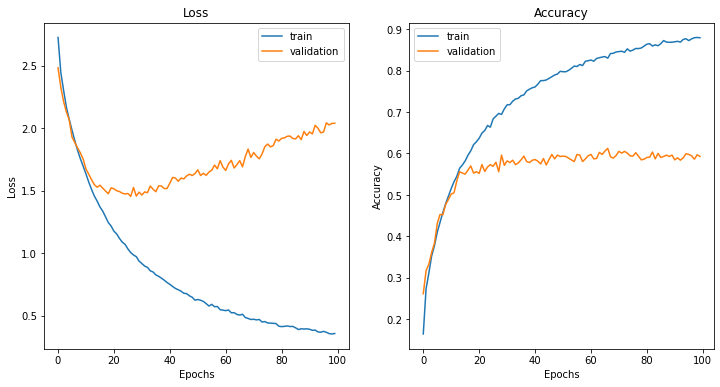

In [69]:
fig, axis = plt.subplots(1,2, figsize=(12, 6))
# plot the loss
axis[0].set_title("Loss")
axis[0].plot(email_hist.history['loss'], label='train')
axis[0].plot(email_hist.history['val_loss'], label='validation')
axis[0].legend()
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel("Loss")

# plot the accuracy
axis[1].set_title("Accuracy")
axis[1].plot(email_hist.history['accuracy'], label='train')
axis[1].plot(email_hist.history['val_accuracy'], label='validation')
axis[1].legend()
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel("Accuracy")

plt.show()

# Stanford Word Embeddings

In [70]:
import gensim
import gensim.downloader as api
import os
from gensim.scripts.glove2word2vec import glove2word2vec

In [71]:
#df = pd.read_csv("D:\\marke\\data\\enron\\data\\cleaned_data.csv")

In [72]:
# load Stanford's pre-trained GloVe embeddings
glove_file = "D:\\Reed\\RelxLearn\\Glove\\glove.6B.300d.txt"
glove_word2vec_file = "glove.6B.300d.txt.word2vec"

glove2word2vec(glove_file, glove_word2vec_file)

(400001, 300)

In [73]:
# glove embeddings
start = time.time()

glove_embeddings = KeyedVectors.load_word2vec_format(glove_word2vec_file, binary=False)

print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  121.93923878669739


In [74]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))

count = 0

for word, i in t.word_index.items():
    if word in glove_embeddings.wv.vocab.keys():
        embedding_vector = glove_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    elif word in email_embeddings.wv.vocab.keys():
        embedding_vector = email_embeddings[word]
        
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    else: 
        count += 1

In [75]:
# define the model
glove_model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=100, trainable=False)
glove_model.add(e)
glove_model.add(LSTM(100, dropout=0.4))
glove_model.add(Flatten())
glove_model.add(Dense(20, activation='softmax'))

# compile the model
glove_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# print model summary
glove_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          52499400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
Total params: 52,661,820
Trainable params: 162,420
Non-trainable params: 52,499,400
_________________________________________________________________


In [76]:
tf.keras.utils.plot_model(glove_model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [77]:
start = time.time()
# train the model
hist = glove_model.fit(train_padded_docs, Y_train, epochs=100, validation_split=0.1)

print("Training time (minutes): ",(round((time.time()-start)/60, 2)))

Epoch 1/100
344/344 [==============================] - 4s 13ms/step - loss: 2.6935 - accuracy: 0.1924 - val_loss: 2.4688 - val_accuracy: 0.2715
Epoch 2/100
344/344 [==============================] - 4s 11ms/step - loss: 2.4510 - accuracy: 0.2791 - val_loss: 2.2465 - val_accuracy: 0.3369
Epoch 3/100
344/344 [==============================] - 4s 11ms/step - loss: 2.2432 - accuracy: 0.3345 - val_loss: 2.1437 - val_accuracy: 0.3704
Epoch 4/100
344/344 [==============================] - 4s 11ms/step - loss: 2.0670 - accuracy: 0.3746 - val_loss: 1.9113 - val_accuracy: 0.3998
Epoch 5/100
344/344 [==============================] - 4s 11ms/step - loss: 2.0954 - accuracy: 0.3821 - val_loss: 2.0007 - val_accuracy: 0.4064
Epoch 6/100
344/344 [==============================] - 4s 11ms/step - loss: 2.0731 - accuracy: 0.3885 - val_loss: 1.8780 - val_accuracy: 0.4350
Epoch 7/100
344/344 [==============================] - 4s 11ms/step - loss: 1.8382 - accuracy: 0.4602 - val_loss: 1.7121 - val_accuracy:

344/344 [==============================] - 4s 11ms/step - loss: 0.2564 - accuracy: 0.9136 - val_loss: 0.9361 - val_accuracy: 0.7792
Epoch 58/100
344/344 [==============================] - 4s 11ms/step - loss: 0.2635 - accuracy: 0.9071 - val_loss: 0.9425 - val_accuracy: 0.7743
Epoch 59/100
344/344 [==============================] - 4s 11ms/step - loss: 0.2597 - accuracy: 0.9100 - val_loss: 0.9402 - val_accuracy: 0.7719
Epoch 60/100
344/344 [==============================] - 4s 11ms/step - loss: 0.2436 - accuracy: 0.9156 - val_loss: 0.9469 - val_accuracy: 0.7776
Epoch 61/100
344/344 [==============================] - 4s 11ms/step - loss: 0.2456 - accuracy: 0.9177 - val_loss: 0.9491 - val_accuracy: 0.7809
Epoch 62/100
344/344 [==============================] - 4s 11ms/step - loss: 0.2407 - accuracy: 0.9161 - val_loss: 0.9689 - val_accuracy: 0.7702
Epoch 63/100
344/344 [==============================] - 4s 11ms/step - loss: 0.2411 - accuracy: 0.9164 - val_loss: 0.9854 - val_accuracy: 0.767

In [78]:
# evaluate the model
train_accr = glove_model.evaluate(train_padded_docs, Y_train, verbose=0)
test_accr = glove_model.evaluate(test_padded_docs, Y_test, verbose=0)

print("Train Accuracy: {:0.3f}    Loss: {:0.3f}".format(train_accr[1], train_accr[0]))
print("Test Accuracy:  {:0.3f}    Loss: {:0.3f}".format(test_accr[1], test_accr[0]))

Train Accuracy: 0.948    Loss: 0.173
Test Accuracy:  0.742    Loss: 1.162


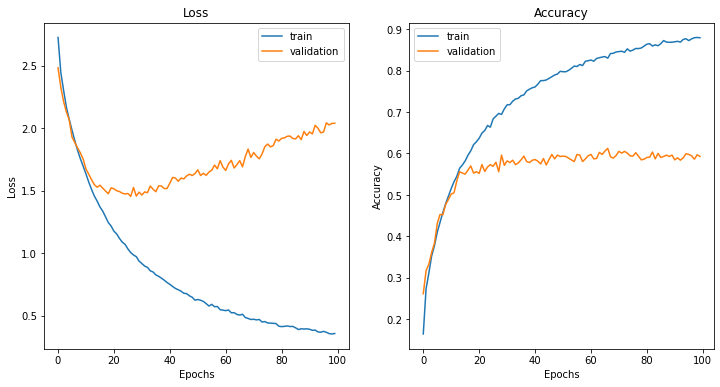

In [79]:
fig, axis = plt.subplots(1,2, figsize=(12, 6))
# plot the loss
axis[0].set_title("Loss")
axis[0].plot(email_hist.history['loss'], label='train')
axis[0].plot(email_hist.history['val_loss'], label='validation')
axis[0].legend()
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel("Loss")

# plot the accuracy
axis[1].set_title("Accuracy")
axis[1].plot(email_hist.history['accuracy'], label='train')
axis[1].plot(email_hist.history['val_accuracy'], label='validation')
axis[1].legend()
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel("Accuracy")

plt.show()

In [80]:
# Transfer learning with Gensim

# https://github.com/RaRe-Technologies/gensim-data

In [81]:
import gensim
import gensim.downloader as api

In [82]:
info = api.info()
pd.DataFrame(info)

,corpora,models
semeval-2016-2017-task3-subtaskBC,"{'num_records': -1, 'record_format': 'dict', '...",NaN
semeval-2016-2017-task3-subtaskA-unannotated,"{'num_records': 189941, 'record_format': 'dict...",NaN
patent-2017,"{'num_records': 353197, 'record_format': 'dict...",NaN
quora-duplicate-questions,"{'num_records': 404290, 'record_format': 'dict...",NaN
wiki-english-20171001,"{'num_records': 4924894, 'record_format': 'dic...",NaN
text8,"{'num_records': 1701, 'record_format': 'list o...",NaN
fake-news,"{'num_records': 12999, 'record_format': 'dict'...",NaN
20-newsgroups,"{'num_records': 18846, 'record_format': 'dict'...",NaN
__testing_matrix-synopsis,{'description': '[THIS IS ONLY FOR TESTING] Sy...,NaN
__testing_multipart-matrix-synopsis,{'description': '[THIS IS ONLY FOR TESTING] Sy...,NaN
